#Demo de TF-Agents para ejemplo del Mono que quiere Banana usando primero Q-Learning y luego una red DQN
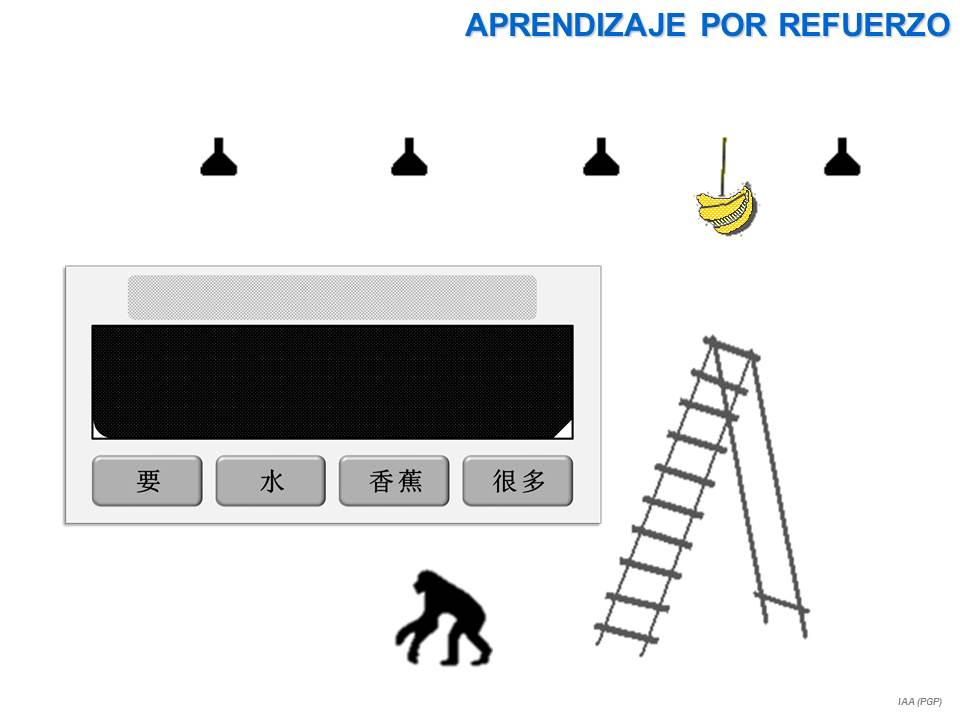

In [1]:
#@title Instalar Paquete de TF-Agents
##!pip install -q tf-agents

# usar esta versión para evitar error 
!pip install tf-agents[reverb]
!git clone https://github.com/tensorflow/agents.git
!cd agents
!git checkout v0.13.0
print("TF-Agentes instalado.")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.1 MB/s 
     |████████████████████████████████| 18.3 MB 114 kB/s 
     |████████████████████████████████| 6.5 MB 32.6 MB/s 
     |████████████████████████████████| 511.7 MB 5.6 kB/s 
     |████████████████████████████████| 5.8 MB 41.3 MB/s 
     |████████████████████████████████| 1.6 MB 52.1 MB/s 
     |████████████████████████████████| 438 kB 58.6 MB/s 
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully u

In [2]:
#@title Cargar Librerías
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
from random import randint
import pandas as pd

from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment

from tf_agents.environments import utils
from tf_agents.specs import array_spec

from tf_agents.policies import random_tf_policy

from tf_agents.trajectories import time_step as ts

from tf_agents.agents.dqn import dqn_agent
from tf_agents.networks import q_network
from tf_agents.utils import common

from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory

tf.compat.v1.enable_v2_behavior()

print("Librerías cargadas.")

Librerías cargadas.


Entorno del Problema:

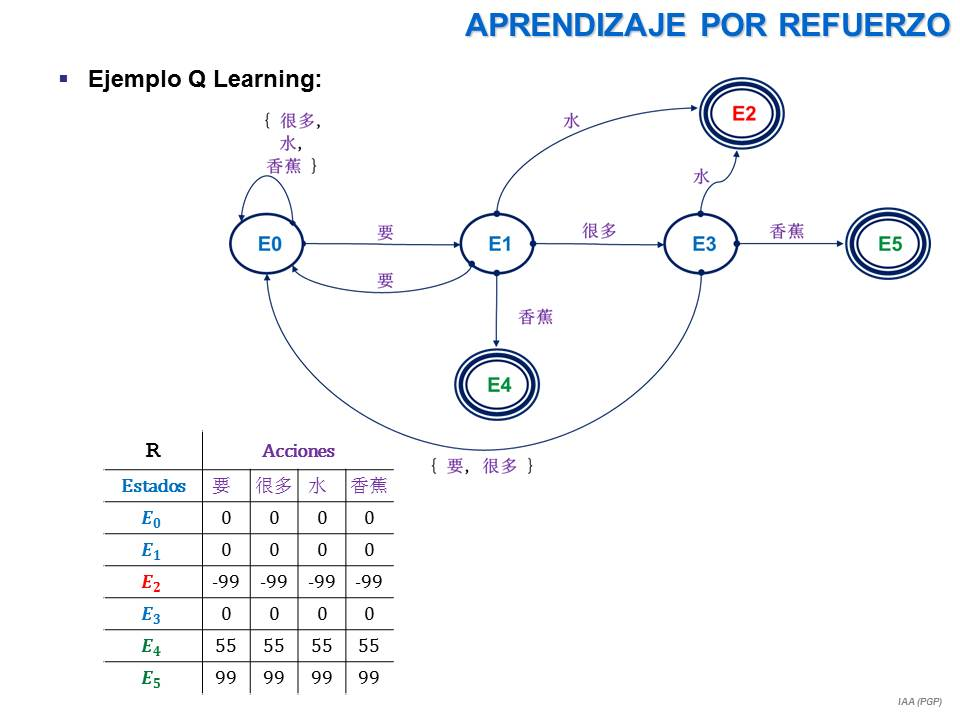


In [3]:
#@title Definir Entorno del Problema 

# variable auxiliar para determinar máximo de acciones a probar antes de abortar
MAX_ACCIONES_REALIZAR = 25
# variables auxiliares para determinar Acciones
posiblesAcciones = [ '要', '水', '香蕉', '很多' ]
posiblesAccionesDescrip = [ 'QUIERO', 'AGUA', 'BANANA', 'MUCHA' ]
# variables auxiliares para determinar Estados, con sus recompensas y sus transiciones posibles
# como a la recompensa lo penaliza la cantidad de iteraciones, 
#   en los estados finales se suma la cantidad mínima para que quede bien si es óptimo
matrizEstados = []
## E0
matrizEstados.append( { 'FINAL': False, 'REWARD': 0, '要' : 1, '水' : 0, '香蕉' : 0, '很多' : 0 } )
## E1
matrizEstados.append( { 'FINAL': False, 'REWARD': 0,  '要' : 0, '水' : 2, '香蕉' : 4, '很多' : 3 } )
## E2 (estado final)
matrizEstados.append( { 'FINAL': True, 'REWARD': (-99 + 1),  '要' : -1, '水' : -1, '香蕉' : -1, '很多' : -1 } )
## E3
matrizEstados.append( { 'FINAL': False, 'REWARD': 0, '要' : 0, '水' : 2, '香蕉' : 5, '很多' : 0 } )
## E4 (estado final)
matrizEstados.append( { 'FINAL': True, 'REWARD': (55 + 1), '要' : -1, '水' : -1, '香蕉' : -1, '很多' : -1 } )
## E5 (estado final)
matrizEstados.append( { 'FINAL': True, 'REWARD': (99 + 2), '要' : -1, '水' : -1, '香蕉' : -1, '很多' : -1 } )
posiblesEstadosDescrip = ['E{:}'.format(x) for x in range(0, len(matrizEstados))]

# Un entorno que represente el juego podría verse así:
class ExperimentoMonoEnv(py_environment.PyEnvironment):

  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=len(posiblesAcciones)-1, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(2,), dtype=np.int32, minimum=0, name='observation')
    self._state = 0
    self._episode_ended = False

  def action_spec(self):
    # devuelve la forma de las acciones
    return self._action_spec

  def observation_spec(self):
    # devuelve la forma de las observaciones   
    return self._observation_spec

  def _reset(self):
    # resetea el entorno
    self._state = 0
    self._cantIteraciones = 0
    self._episode_ended = False
    return ts.restart(np.array([self._state, -1], dtype=np.int32))

  def _step(self, action):
    # aplica una acción sobre el entorno
    
    if self._episode_ended:
      # si el entorno está finalizado, lo resetea
      return self.reset()
    
    if action < 0 or action > len(posiblesAcciones):
      raise ValueError("ID de acción inválida ", action,"!")

    # Aplica la acción correspondiente
    accionTipo = posiblesAcciones[action]
    if accionTipo in matrizEstados[self._state]:
        self._state = matrizEstados[self._state][accionTipo]
    else:      
      raise ValueError("Tipo de acción inválida: ", accionTipo,"!")

    # determina si debe finalizar o no
    if (self._state < 0) or (abs(self._cantIteraciones) >= abs(MAX_ACCIONES_REALIZAR)):
      # llegó a un estado inválido,
      # o si la cantidad de iteraciones llega al límite
      # fuerza que finaliza
      self._episode_ended = True
    else:
      # llegó a un estado final
      self._episode_ended =  matrizEstados[self._state]["FINAL"]

    if self._episode_ended:
      # si finaliza
      # devuelve el reward (siempre se maximiza)
      reward = matrizEstados[self._state]["REWARD"] + self._cantIteraciones
      return ts.termination(np.array([self._state, reward], dtype=np.int32), reward)
    else:
      # si no finaliza
      self._cantIteraciones = self._cantIteraciones - 1
      return ts.transition(
          np.array([self._state, 0], dtype=np.int32), reward=self._cantIteraciones, discount=0.9)

print("Entorno del Problema definido.")

# Definir entornos de entrenamiento y evaluación
train_py_env = ExperimentoMonoEnv()
eval_py_env = ExperimentoMonoEnv()

# Definir wrapper para convertir en entornos TF
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# define política al azar independiente del Agente
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

print("Entornos de entrenamiento y prueba definidos. ")

# definir simulador para probar el entorno
def SimularEntorno(eval_env, policy, titulo, mostarDetalleStep=False):
    print("\n** ", titulo, "**")                   
    # muesta estado inicial
    time_step = eval_env.reset()  
    ob = time_step.observation.numpy()[0]
    if mostarDetalleStep:
      print(" Ini: Estado ", posiblesEstadosDescrip[ob[0]], "[", time_step, "]")      
    else:
      print(" Ini: Estado ", posiblesEstadosDescrip[ob[0]])      
    j = 1
    secuenciaAcciones = ""
    while not time_step.is_last():
      # la política determina la acción a realizar
      action_step = policy.action( time_step )
      time_step = eval_env.step( action_step.action )
      # recupera la observación y muestra el nuevo estado
      ac = action_step.action.numpy()[0]
      ob = time_step.observation.numpy()[0]
      descAccion = "acción " + posiblesAcciones[ ac ] 
      if j > 1:
        secuenciaAcciones = secuenciaAcciones + " + "
      secuenciaAcciones = secuenciaAcciones + posiblesAccionesDescrip[ ac ]
      if mostarDetalleStep:
        print(" #", j, ": ", descAccion, "-> Estado ", posiblesEstadosDescrip[ob[0]], "[", time_step, "]")
      else:
        print(" #", j, ": ", descAccion, "-> Estado ", posiblesEstadosDescrip[ob[0]])
      j = j + 1

    # muestra estado final
    ob = time_step.observation.numpy()[0]
    r = time_step.reward.numpy()
    if mostarDetalleStep:
      print(" Fin -> Estado ", posiblesEstadosDescrip[ob[0]], "[", time_step, "]")
    else:
      print(" Fin -> Estado ", posiblesEstadosDescrip[ob[0]])
    print(" Secuencia de Acciones = ", secuenciaAcciones)
    print(' Recompensa Final = ', r[0])
    return r[0]


# función auxiliar para comparar
def compararRtdosPolicy(cantidad_probar, eval_env, policy1, policy2, descPol1="Agente 1", descPol2="Agente 2"):
  prom1 = 0
  prom2 = 0
  for i in range(cantidad_probar):
    print("\n> Prueba ", i+1, ":")
    # Probar 1
    valor1 = SimularEntorno(eval_env, policy1, "Resultados de " + descPol1, False) 
    prom1 = prom1 + valor1
    # Probar 2
    valor2 = SimularEntorno(eval_env, policy2, "Resultados de " + descPol2, False) 
    prom2 = prom2 + valor2
    # Decide Ganador
    strMostrar = "\n--> " + descPol1 + " (%s) genera" % valor1
    if valor1 > valor2:
      strMostrar = strMostrar + " MEJOR "
    elif valor1 < valor2:
      strMostrar = strMostrar + " PEOR "
    else:
      strMostrar = strMostrar + " IGUAL "
    strMostrar = strMostrar + "resultado que " + descPol2 + " (%s)." % valor2
    print(strMostrar)
  # Decide Ganador General
  if cantidad_probar > 0:
    prom1 = prom1 / cantidad_probar
    prom2 = prom2 / cantidad_probar
    print("\n================================================================================================\n")
    strMostrar = " * En Promedio " + descPol1 + " (%s) genera" % prom1
    if prom1 > prom2:
      strMostrar = strMostrar + " MEJORES "
    elif prom1 < prom2:
      strMostrar = strMostrar + " PEORES "
    else:
      strMostrar = strMostrar + " IGUALES "
    strMostrar = strMostrar + "resultados que " + descPol2 + " (%s)." % prom2
    print(strMostrar)
    print("\n================================================================================================\n")

print("Simulador del entorno definido.")

# Probar el entorno definido con Política Aleatoria (opcional)
Probar_Entorno = True #@param {type:"boolean"}
MostarDetalleSteps = False #@param {type:"boolean"}

if Probar_Entorno:
  SimularEntorno(eval_env, random_policy, "Probando el entorno del problema al azar", MostarDetalleSteps)

Entorno del Problema definido.
Entornos de entrenamiento y prueba definidos. 
Simulador del entorno definido.

**  Probando el entorno del problema al azar **
 Ini: Estado  E0
 # 1 :  acción 要 -> Estado  E1
 # 2 :  acción 要 -> Estado  E0
 # 3 :  acción 水 -> Estado  E0
 # 4 :  acción 香蕉 -> Estado  E0
 # 5 :  acción 很多 -> Estado  E0
 # 6 :  acción 要 -> Estado  E1
 # 7 :  acción 很多 -> Estado  E3
 # 8 :  acción 要 -> Estado  E0
 # 9 :  acción 要 -> Estado  E1
 # 10 :  acción 水 -> Estado  E2
 Fin -> Estado  E2
 Secuencia de Acciones =  QUIERO + QUIERO + AGUA + BANANA + MUCHA + QUIERO + MUCHA + QUIERO + QUIERO + AGUA
 Recompensa Final =  -107.0


##Q-Learning

In [4]:
#@title Define clase auxiliar Policy para Q-Learning

## funciones auxiliares basadas en:
##  https://rubikscode.net/2019/06/24/introduction-to-q-learning-with-python-and-open-ai-gym/


from tf_agents.policies.fixed_policy import FixedPolicy
from tf_agents.trajectories import policy_step
from tf_agents.utils import nest_utils
from tf_agents.specs import tensor_spec
from tf_agents.typing import types
from typing import Optional, Text

# Se hereda de FixedPolicy porque es una simple para tener como base
class QL_TF_Policy(FixedPolicy):
    
  def __init__(self,
               posiblesEstadosList, 
               posiblesAccionesList,
               time_step_spec: ts.TimeStep,
               action_spec: types.NestedTensorSpec,
               policy_info: types.NestedTensorSpec = (),
               info_spec: types.NestedTensorSpec = (),
               name: Optional[Text] = None):    
    
      # llama al padre
      super(FixedPolicy, self).__init__(time_step_spec, action_spec, clip=False,
                                      info_spec=info_spec,
                                      name=name,
                                      emit_log_probability=False)             
      # guarda valores auxiliares
      self._policy_info = policy_info
      self._time_step_spec = tensor_spec.from_spec(time_step_spec)
      self._action_spec = tensor_spec.from_spec(action_spec)   
      # inicializa parametros de matriz
      if (posiblesEstadosList is None) or (len(posiblesEstadosList)<2):
       raise ValueError('No se ha definida la lista de posibles estdos!' )
      self._posiblesEstadosList = posiblesEstadosList
      self._cantEstados = len(posiblesEstadosList)
      if (posiblesAccionesList is None) or (len(posiblesAccionesList)<2):
       raise ValueError('No se ha definida la lista de posibles acciones!' )
      self._posiblesAccionesList = posiblesAccionesList
      self._cantAcciones = len(posiblesAccionesList)
      self.ResetQ()
  
  # funcion auxiliar para inicializar la matriz
  def ResetQ(self):     
      self._Qtable = np.zeros([self._cantEstados, self._cantAcciones])

  # función auxiliar de entrenamiento
  def TrainQ(self, env, random_policy, alpha = 0.1, gamma = 0.6, epsilon = 0.1, cant_ciclos_entrenamiento = 100000, log_cada_ciclos = 1000):
      # ejecuta el entrenamiento
      for step in range(1, cant_ciclos_entrenamiento+1):
          # Resetea el enviroment
          time_step = env.reset()  
          ob = time_step.observation.numpy()[0]
          state = ob[0] 
          secuenciaAcciones = ""
          j = 1
          # Simula      
          while not time_step.is_last():
              # Considera lo aprendido o toma al azar depende de azar y epsilon
              if random.uniform(0, 1) < epsilon:
                  # toma al azar
                  action_step = random_policy.action( time_step )
                  accionAplicar = action_step.action.numpy()[0]
              else:
                  # toma de Matriz-Q
                  accionAplicar = np.argmax( self._Qtable[state] )
              if j > 1:
                secuenciaAcciones = secuenciaAcciones + " + "
              secuenciaAcciones = secuenciaAcciones + self._posiblesAccionesList[ accionAplicar ]	
              j = j + 1
              # Aplica la Accion    
              time_step = env.step( accionAplicar )
              ob = time_step.observation.numpy()[0]
              next_state = ob[0]   
              r = time_step.reward.numpy()[0] 
              # Recalcula Q
              q_value = self._Qtable[state, accionAplicar]
              max_value = np.max(self._Qtable[next_state])
              new_q_value = (1 - alpha) * q_value + alpha * (r + gamma * max_value)                       
              # Actualiza Matriz-Q
              self._Qtable[state, accionAplicar] = new_q_value
              state = next_state        
          # muestra estado
          if log_cada_ciclos > 0:
            if (step == 1) or (step % log_cada_ciclos == 0):
              print('step = {0}: Recompensa = {1} - Acciones({2}) = {3} '.format(step, r, (j-1), secuenciaAcciones))  
      # Devuelve Matriz-Q
      return self._Qtable   


  # función auxiliar para mostrar matri Q
  def MostrarQ(self):
        # muestra Q table
        print('\n Matriz-Q entrenada: ')
        cm = self._Qtable 
        cmtx = pd.DataFrame(
            cm, 
            index=self._posiblesEstadosList, 
            columns=self._posiblesAccionesList
          )
        # agrega para poder mostrar la matrix de confusión completa
        pd.options.display.max_rows = 100
        pd.options.display.max_columns = 100
        print(cmtx)
        print("\n")


  # devuelve la accion que se debe aplicar usando la matrix Q entrenada
  def _action(self, time_step, policy_state, seed):    
      # determina la accion a realizar
      # obtiene estado actual
      ob = time_step.observation.numpy()[0]
      state = ob[0] 
      # toma de Matriz-Q      
      accionAplicar = np.argmax( self._Qtable[state] )
      # formatea el valor a devolver usando la action_spec y time_step_spec
      def convert(action, spec):
        return tf.convert_to_tensor(value=action, dtype=spec.dtype)
      self._action_value = tf.nest.map_structure(convert, accionAplicar,
                                                  self._action_spec)
      outer_shape = nest_utils.get_outer_shape(time_step, self._time_step_spec)
      action = tf.nest.map_structure(lambda t: common.replicate(t, outer_shape),
                                   self._action_value)
      # devuelve la accion
      return policy_step.PolicyStep(action, policy_state, self._policy_info)


print("Clase QL_TF_Policy creada.")

Clase QL_TF_Policy creada.


In [5]:
#@title Entrenar con algoritmo Q-Learning

# parámetros
alpha = 0.1 #@param {type:"number"}
gamma = 0.6 #@param {type:"number"}
epsilon = 0.3 #@param {type:"number"}
cant_ciclos_entrenamiento = 1500 #@param {type:"integer"}
log_cada_ciclos = 200  #@param {type:"integer"}
if alpha <= 0.0:
   alpha = 0.001
if gamma <= 0.0:
    gamma = 0.001
if epsilon <= 0.0:
   epsilon = 0.001    
if cant_ciclos_entrenamiento <= 10:
   cant_ciclos_entrenamiento = 10    



# instancia política de Q Learning
ql_policy = QL_TF_Policy(posiblesEstadosDescrip,
                         posiblesAccionesDescrip,
                         train_env.time_step_spec(),
                         train_env.action_spec())

# hace el entrenamiento
print("** Comienza el Entrenamiento:\n")
ql_policy.TrainQ(train_env, random_policy, 
                 alpha, gamma, epsilon, 
                 cant_ciclos_entrenamiento, 
                 log_cada_ciclos)
print("\n** Entrenamiento Finalizado **")
# muestra matriz
ql_policy.MostrarQ()


** Comienza el Entrenamiento:

step = 1: Recompensa = -99.0 - Acciones(2) = QUIERO + AGUA 
step = 200: Recompensa = -100.0 - Acciones(3) = MUCHA + QUIERO + AGUA 
step = 400: Recompensa = 54.0 - Acciones(3) = MUCHA + QUIERO + BANANA 
step = 600: Recompensa = 55.0 - Acciones(2) = QUIERO + BANANA 
step = 800: Recompensa = -99.0 - Acciones(2) = QUIERO + AGUA 
step = 1000: Recompensa = 55.0 - Acciones(2) = QUIERO + BANANA 
step = 1200: Recompensa = 99.0 - Acciones(3) = QUIERO + MUCHA + BANANA 
step = 1400: Recompensa = 55.0 - Acciones(2) = QUIERO + BANANA 

** Entrenamiento Finalizado **

 Matriz-Q entrenada: 
       QUIERO       AGUA     BANANA      MUCHA
E0  32.314741  17.352941  17.593650  16.981130
E1  15.850431 -99.750883  54.416667  56.332812
E2   0.000000   0.000000   0.000000   0.000000
E3  14.366193 -97.632095  98.292551  14.520857
E4   0.000000   0.000000   0.000000   0.000000
E5   0.000000   0.000000   0.000000   0.000000




In [6]:
#@title Probar Q-Learning Entrenado contra el Azar
cantidad_probar = 5 # @param {type:"integer"}

compararRtdosPolicy(cantidad_probar, eval_env, ql_policy, random_policy, "Agente Q-Learning entrenado", "el Azar")



> Prueba  1 :

**  Resultados de Agente Q-Learning entrenado **
 Ini: Estado  E0
 # 1 :  acción 要 -> Estado  E1
 # 2 :  acción 很多 -> Estado  E3
 # 3 :  acción 香蕉 -> Estado  E5
 Fin -> Estado  E5
 Secuencia de Acciones =  QUIERO + MUCHA + BANANA
 Recompensa Final =  99.0

**  Resultados de el Azar **
 Ini: Estado  E0
 # 1 :  acción 香蕉 -> Estado  E0
 # 2 :  acción 很多 -> Estado  E0
 # 3 :  acción 香蕉 -> Estado  E0
 # 4 :  acción 香蕉 -> Estado  E0
 # 5 :  acción 香蕉 -> Estado  E0
 # 6 :  acción 很多 -> Estado  E0
 # 7 :  acción 香蕉 -> Estado  E0
 # 8 :  acción 香蕉 -> Estado  E0
 # 9 :  acción 香蕉 -> Estado  E0
 # 10 :  acción 很多 -> Estado  E0
 # 11 :  acción 香蕉 -> Estado  E0
 # 12 :  acción 水 -> Estado  E0
 # 13 :  acción 要 -> Estado  E1
 # 14 :  acción 很多 -> Estado  E3
 # 15 :  acción 很多 -> Estado  E0
 # 16 :  acción 要 -> Estado  E1
 # 17 :  acción 香蕉 -> Estado  E4
 Fin -> Estado  E4
 Secuencia de Acciones =  BANANA + MUCHA + BANANA + BANANA + BANANA + MUCHA + BANANA + BANANA + BANANA + MUCHA + 

##DQN

In [7]:
#@title Definir el Agente tipo DQN

learning_rate = 1e-3  # @param {type:"number"}
cant_neuronas_ocultas = 50 # @param {type:"integer"}
if cant_neuronas_ocultas < 10:
  cant_neuronas_ocultas = 10

# Define cantidad de neuronas ocultas para RNA-Q
fc_layer_params = (cant_neuronas_ocultas,)

# Define RNA-Q
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

# Define el agente de tipo Q
ag = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

ag.initialize()

# define política para evaluación para el Agente
eval_policy = ag.policy

# define política para recolección de datos para el Agente
collect_policy = ag.collect_policy

print("Agente DQN inicializado. ")

Agente DQN inicializado. 


In [8]:
#@title Definir Métricas para evaluación de Agente DQN

# Se usa el promedio de la recompensa (la más común)
# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0
    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

print("Métricas definidas.")

Métricas definidas.


In [9]:
#@title Preparar datos para Entrenamiento de Agente DQN

initial_collect_steps =   1000# @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}
batch_size = 64  # @param {type:"integer"}


# Define 'Replay Buffer' para que el agente recuerde las observaciones realizadas
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec = ag.collect_data_spec,
    batch_size = train_env.batch_size,
    max_length = replay_buffer_max_length)

# Recolecta datos generados al azar
# This loop is so common in RL, that we provide standard implementations. 
# For more details see the drivers module.
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers

def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)

print("\nDatos recolectados.")

# Muestra ejemplo de los datos recolectados
##iter(replay_buffer.as_dataset()).next()

# Preparar los datos recolectados con trajectories de shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)
iterator = iter(dataset)
# Muestra ejemplo 
##iterator.next()
print("\nDataset creado.")


Datos recolectados.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.

Dataset creado.


In [10]:
#@title Entrenar al Agente DQN

cant_ciclos_entrenamiento = 5000 # @param {type:"integer"}
log_cada_ciclos = 200  # @param {type:"integer"}
evaluar_cada_ciclos = 1000  # @param {type:"integer"}
cant_episodios_evaluacion = 25  # @param {type:"integer"}

#  Optimize by wrapping some of the code in a graph using TF function (Optional)
ag.train = common.function(ag.train)

# Reset the train step
ag.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, ag.policy, cant_episodios_evaluacion)
ar_ciclo = []
ar_returns = []
ar_loss = []

print("\n** Comienza el Entrenamiento **\n")
for _ in range(cant_ciclos_entrenamiento):

  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_data(train_env, ag.collect_policy, replay_buffer, collect_steps_per_iteration)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = ag.train(experience).loss

  step = ag.train_step_counter.numpy()

  if (step == 1) or (step % log_cada_ciclos == 0):
    print('step = {0}: loss = {1:.3f}'.format(step, train_loss))    
    ar_ciclo.append( step )
    ar_loss.append( train_loss )
    avg_return = compute_avg_return(eval_env, ag.policy, cant_episodios_evaluacion)
    ar_returns.append( avg_return )

    if (step == 1) or (step % evaluar_cada_ciclos == 0):
      print('step = {0}: Promedio Recompensa = {1:.1f}'.format(step, avg_return))

print("\n** Entrenamiento Finalizado **\n")



** Comienza el Entrenamiento **

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 1: loss = 633.115
step = 1: Promedio Recompensa = -350.0
step = 200: loss = 494.257
step = 400: loss = 139.032
step = 600: loss = 404.726
step = 800: loss = 148.509
step = 1000: loss = 291.646
step = 1000: Promedio Recompensa = 54.0
step = 1200: loss = 239.096
step = 1400: loss = 234.206
step = 1600: loss = 211.784
step = 1800: loss = 165.943
step = 2000: loss = 149.791
step = 2000: Promedio Recompensa = 54.0
step = 2200: loss = 99.531
step = 2400: loss = 19.841
step = 2600: loss = 103.018
step = 2800: loss = 65.838
step = 3000: loss = 153.588
step = 3000: Promedio Recompensa = 54.0
step = 3200: loss = 77.478
step = 3400: loss = 21.318
step = 3600: loss = 79.247
step = 3800: loss = 18.306
step = 4000: loss = 122.594

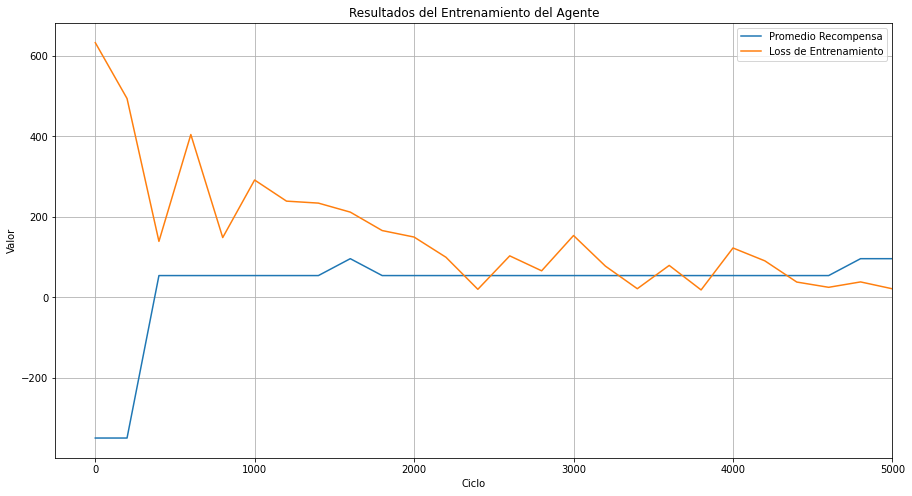

In [11]:
#@title Mostrar Gráficos del Entrenamiento del Agente DQN

plt.figure(figsize=(15,8)) 
plt.plot( ar_ciclo, ar_returns)
plt.plot( ar_ciclo, ar_loss )
plt.title("Resultados del Entrenamiento del Agente")
plt.legend(['Promedio Recompensa', 'Loss de Entrenamiento'], loc='upper right')
plt.ylabel('Valor')
plt.xlabel('Ciclo')
plt.xlim(right=max(ar_ciclo))   
##plt.ylim(top=21)    
plt.grid(True)
plt.show()


In [12]:
#@title Probar el Agente DQN Entrenado contra el Azar
cantidad_probar = 5 # @param {type:"integer"}

compararRtdosPolicy(cantidad_probar, eval_env, ag.policy, random_policy, "Agente DQN entrenado", "el Azar")



> Prueba  1 :

**  Resultados de Agente DQN entrenado **
 Ini: Estado  E0
 # 1 :  acción 要 -> Estado  E1
 # 2 :  acción 很多 -> Estado  E3
 # 3 :  acción 香蕉 -> Estado  E5
 Fin -> Estado  E5
 Secuencia de Acciones =  QUIERO + MUCHA + BANANA
 Recompensa Final =  99.0

**  Resultados de el Azar **
 Ini: Estado  E0
 # 1 :  acción 香蕉 -> Estado  E0
 # 2 :  acción 要 -> Estado  E1
 # 3 :  acción 水 -> Estado  E2
 Fin -> Estado  E2
 Secuencia de Acciones =  BANANA + QUIERO + AGUA
 Recompensa Final =  -100.0

--> Agente DQN entrenado (99.0) genera MEJOR resultado que el Azar (-100.0).

> Prueba  2 :

**  Resultados de Agente DQN entrenado **
 Ini: Estado  E0
 # 1 :  acción 要 -> Estado  E1
 # 2 :  acción 很多 -> Estado  E3
 # 3 :  acción 香蕉 -> Estado  E5
 Fin -> Estado  E5
 Secuencia de Acciones =  QUIERO + MUCHA + BANANA
 Recompensa Final =  99.0

**  Resultados de el Azar **
 Ini: Estado  E0
 # 1 :  acción 很多 -> Estado  E0
 # 2 :  acción 水 -> Estado  E0
 # 3 :  acción 很多 -> Estado  E0
 # 4 :  acció

## Comparar Q-Learning y DQN

In [13]:
#@title Probar Q-Learning Entrenado contra Agente DQN Entrenado
cantidad_probar = 10 # @param {type:"integer"}

compararRtdosPolicy(cantidad_probar, eval_env, ag.policy, ql_policy, "Agente DQN", "Agente Q-Learning")



> Prueba  1 :

**  Resultados de Agente DQN **
 Ini: Estado  E0
 # 1 :  acción 要 -> Estado  E1
 # 2 :  acción 很多 -> Estado  E3
 # 3 :  acción 香蕉 -> Estado  E5
 Fin -> Estado  E5
 Secuencia de Acciones =  QUIERO + MUCHA + BANANA
 Recompensa Final =  99.0

**  Resultados de Agente Q-Learning **
 Ini: Estado  E0
 # 1 :  acción 要 -> Estado  E1
 # 2 :  acción 很多 -> Estado  E3
 # 3 :  acción 香蕉 -> Estado  E5
 Fin -> Estado  E5
 Secuencia de Acciones =  QUIERO + MUCHA + BANANA
 Recompensa Final =  99.0

--> Agente DQN (99.0) genera IGUAL resultado que Agente Q-Learning (99.0).

> Prueba  2 :

**  Resultados de Agente DQN **
 Ini: Estado  E0
 # 1 :  acción 要 -> Estado  E1
 # 2 :  acción 很多 -> Estado  E3
 # 3 :  acción 香蕉 -> Estado  E5
 Fin -> Estado  E5
 Secuencia de Acciones =  QUIERO + MUCHA + BANANA
 Recompensa Final =  99.0

**  Resultados de Agente Q-Learning **
 Ini: Estado  E0
 # 1 :  acción 要 -> Estado  E1
 # 2 :  acción 很多 -> Estado  E3
 # 3 :  acción 香蕉 -> Estado  E5
 Fin -> Estado 